In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from tqdm import tqdm

from mpl_toolkits.basemap import Basemap

#pip install https://github.com/matplotlib/basemap/archive/master.zip

In [93]:
data_path = "../data/AB_NYC_2019.csv"
!wc {data_path}

  49081  384069 7077973 ../data/AB_NYC_2019.csv


In [94]:
df_tmp = pd.read_csv(
    data_path,
    nrows=5
)

columns = list(df_tmp.columns)

print("\nFeatures in dataset:")
for column in columns:
    print(column)

traintypes = {
    'id': 'int32',
    'name': 'str',
    'host_id': 'int32',
    'host_name': 'str',
    'neighbourhood_group': 'str',
    'neighbourhood': 'str',
    'latitude': 'float32',
    'longitude': 'float32',
    'room_type': 'str',
    'price': 'uint16',
    'minimum_nights': 'uint16',
    'number_of_reviews': 'uint16',
    'last_review': 'str',
    'reviews_per_month': 'float16',
    'calculated_host_listings_count': 'uint16',
    'availability_365': 'uint16',
}
cols = list(traintypes.keys())

df_list = []

chunksize = 1_000_000

for df_chunk in tqdm(
    pd.read_csv(
        data_path, 
        dtype=traintypes, 
        chunksize=chunksize
    )
):
    df_chunk['last_review'] = df_chunk['last_review'].str.slice(0, 16)
    df_chunk['last_review'] = pd.to_datetime(df_chunk['last_review'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)
    
bnb_df = pd.concat(df_list[0:1])
bnb_df = bnb_df[~bnb_df.isin([np.nan, np.inf, -np.inf]).any(1)]

del df_list

bnb_df.head()


Features in dataset:
id
name
host_id
host_name
neighbourhood_group
neighbourhood
latitude
longitude
room_type
price
minimum_nights
number_of_reviews
last_review
reviews_per_month
calculated_host_listings_count
availability_365


1it [00:00,  3.91it/s]


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647491,-73.972366,Private room,149,1,9,2018-10-19 00:00:00+00:00,0.209961,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753620,-73.983772,Entire home/apt,225,1,45,2019-05-21 00:00:00+00:00,0.379883,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.685139,-73.959763,Entire home/apt,89,1,270,2019-07-05 00:00:00+00:00,4.640625,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.798512,-73.943993,Entire home/apt,80,10,9,2018-11-19 00:00:00+00:00,0.099976,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.747669,-73.974998,Entire home/apt,200,3,74,2019-06-22 00:00:00+00:00,0.589844,1,129


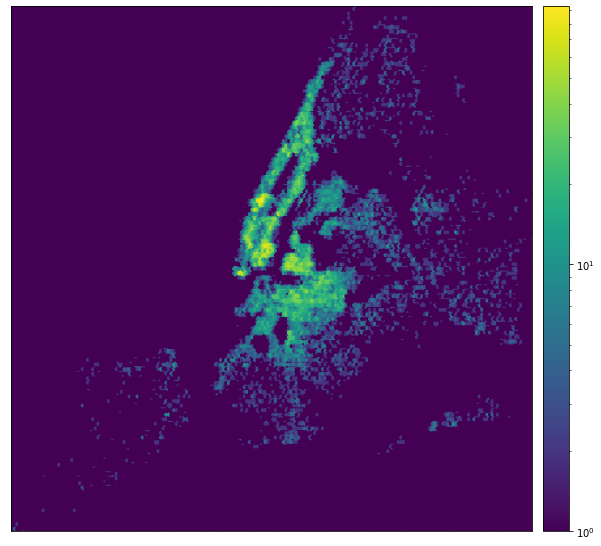

In [95]:
scatter = False

fig = plt.figure(figsize=(10,10))

# https://boundingbox.klokantech.com/
# (latitude, longitude) == (row, col)
bbox_raw = [
    [-74.25909008,40.47739894], # lower-left
    [-73.70018092,40.47739894], # upper-left
    [-73.70018092,40.91617849], # upper-right
    [-74.25909008,40.91617849], # lower-right
    [-74.25909008,40.47739894]  # lower-left
]

min_lat = min([coord[1] for coord in bbox_raw])
min_lon = min([coord[0] for coord in bbox_raw])

max_lat = max([coord[1] for coord in bbox_raw])
max_lon = max([coord[0] for coord in bbox_raw])

center_lat = min_lat + max_lat / 2
center_lon = min_lon + max_lon / 2

ll_crnr = (min_lat, min_lon)
lr_crnr = (min_lat, max_lon)

ur_crnr = (max_lat, max_lon)
ul_crnr = (max_lat, min_lon)

shape_path = "../data/shapefiles/nyc_neighborhoods.shp"

m = Basemap(
    llcrnrlon=bnb_df["longitude"].min(),
    llcrnrlat=bnb_df["latitude"].min(),
    urcrnrlon=bnb_df["longitude"].max(),
    urcrnrlat=bnb_df["latitude"].max(),
    epsg=2263
)

m.arcgisimage(service='World_Street_Map', xpixels = 3000)
-0.1
x, y = m(bnb_df["longitude"].values, bnb_df["latitude"].values)

if scatter:
    map_scatter = m.scatter(
        x,y,
        s=1,
        alpha=0.2,
        c=bnb_df["price"].values,
        cmap="viridis"
    )
    cbar = m.colorbar(map_scatter)

else:
    map_hex = m.hexbin(x, y, gridsize=200, bins="log")
    cbar = m.colorbar(map_hex)

plt.show()

ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not 0             Brooklyn
1            Manhattan
3             Brooklyn
4            Manhattan
5            Manhattan
             ...      
48782        Manhattan
48790           Queens
48799    Staten Island
48805            Bronx
48852         Brooklyn
Name: neighbourhood_group, Length: 38821, dtype: object.

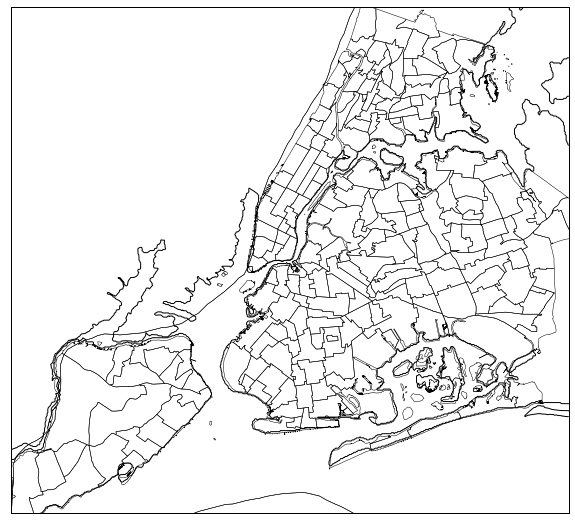

In [96]:
fig = plt.figure(figsize=(10,10))

# https://boundingbox.klokantech.com/
# (latitude, longitude) == (row, col)
bbox_raw = [
    [-74.25909008,40.47739894], # lower-left
    [-73.70018092,40.47739894], # upper-left
    [-73.70018092,40.91617849], # upper-right
    [-74.25909008,40.91617849], # lower-right
    [-74.25909008,40.47739894]  # lower-left
]

min_lat = min([coord[1] for coord in bbox_raw])
min_lon = min([coord[0] for coord in bbox_raw])

max_lat = max([coord[1] for coord in bbox_raw])
max_lon = max([coord[0] for coord in bbox_raw])

center_lat = min_lat + max_lat / 2
center_lon = min_lon + max_lon / 2

ll_crnr = (min_lat, min_lon)
lr_crnr = (min_lat, max_lon)

ur_crnr = (max_lat, max_lon)
ul_crnr = (max_lat, min_lon)

shape_path = "../data/shapefiles/nyc_neighborhoods"

m = Basemap(
    llcrnrlon=bnb_df["longitude"].min(),
    llcrnrlat=bnb_df["latitude"].min(),
    urcrnrlon=bnb_df["longitude"].max(),
    urcrnrlat=bnb_df["latitude"].max(),
    projection="mill",
    resolution="f"
)

m.drawmapboundary()
m.drawcoastlines()
m.drawstates()
m.drawrivers()

m.readshapefile(shape_path, "neighborhoods")

x, y = m(bnb_df["longitude"].values, bnb_df["latitude"].values)

colors = {
    "Manhattan": "red",
    "Brooklyn": "blue",
    "Queens": "green",
    "Staten Island": "orange",
    "Bronx": "purple"
}

map_scatter = m.scatter(
    x,y,
    s=1,
    alpha=0.2,
    c=bnb_df["neighborhood_group"].apply(lambda x: colors[x])
)

plt.show()